In [24]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import download_mnist_data, get_mnist_image_np_arrays, UMAPImageDataset
from utils.autoencoder import MNISTAutoencoder
from utils.loss import UMAPAutoencoderLoss
from utils.train_functions import (
    train_autoencoder_with_umap,
    test_autoencoder_reconstruction,
    test_autoencoder_umap_embedding,
)

# Load MNIST images

In [2]:
download_mnist_data()

Data is already downloaded. Skipping download.


In [3]:
train_images, test_images = get_mnist_image_np_arrays()

# UMAP embeddings

In [4]:
embedding_dim = 2

full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)
reducer = umap.UMAP(n_components=embedding_dim)
full_embeddings = reducer.fit_transform(flat_full_images)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

In [8]:
# Save full embeddings to a file
project_dir = Path("..").resolve()
embeddings_file = (
    project_dir
    / "data"
    / "mnist"
    / "umap_embeddings"
    / f"embeddings_d{embedding_dim}.npy"
)
embeddings_file.parent.mkdir(parents=True, exist_ok=True)
np.save(embeddings_file, full_embeddings)


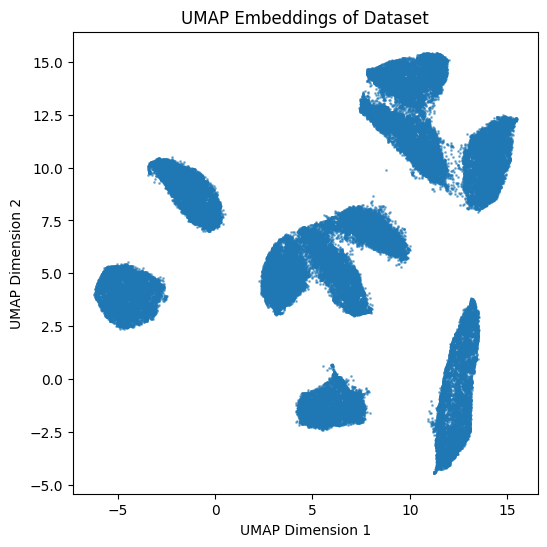

In [9]:
# Plot embeddings
plt.figure(figsize=(6, 6))
plt.scatter(full_embeddings[:, 0], full_embeddings[:, 1], s=1, alpha=0.5)
plt.title("UMAP Embeddings of Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


# Train UMAP AutoEncoder

In [20]:
# Datasets
flat_train_images = train_images.reshape(train_images.shape[0], -1)
flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_dataset = UMAPImageDataset(
    images=flat_train_images, umap_embeddings=train_embeddings
)
test_dataset = UMAPImageDataset(
    images=flat_test_images, umap_embeddings=test_embeddings
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [21]:
input_dim = flat_full_images.shape[1]
autoencoder = MNISTAutoencoder(input_dim=input_dim, embedding_dim=embedding_dim)
print(autoencoder)

MNISTAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [22]:
# Train
criterion = UMAPAutoencoderLoss(reconstruction_weight=0.5, umap_weight=0.5)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

num_epochs = 20

train_autoencoder_with_umap(
    model=autoencoder,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

Epoch [1/20], Loss: 2.7824
Epoch [2/20], Loss: 0.7751
Epoch [3/20], Loss: 0.5446
Epoch [4/20], Loss: 0.4271
Epoch [5/20], Loss: 0.3500
Epoch [6/20], Loss: 0.2907
Epoch [7/20], Loss: 0.2461
Epoch [8/20], Loss: 0.2144
Epoch [9/20], Loss: 0.1810
Epoch [10/20], Loss: 0.1632
Epoch [11/20], Loss: 0.1437
Epoch [12/20], Loss: 0.1287
Epoch [13/20], Loss: 0.1161
Epoch [14/20], Loss: 0.1064
Epoch [15/20], Loss: 0.0955
Epoch [16/20], Loss: 0.0890
Epoch [17/20], Loss: 0.0867
Epoch [18/20], Loss: 0.0842
Epoch [19/20], Loss: 0.0782
Epoch [20/20], Loss: 0.0711
Training complete.


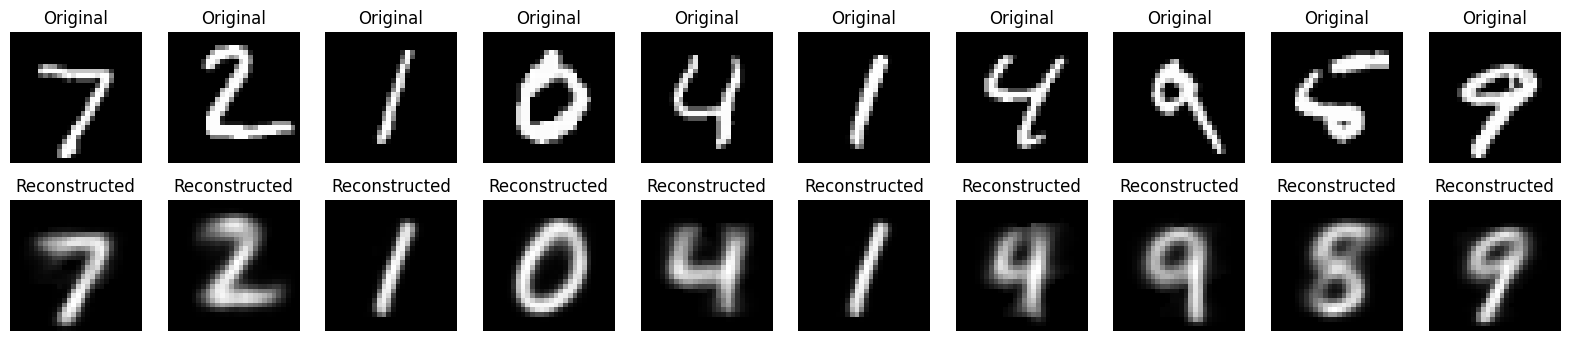

In [23]:
# Plot example image and reconstructions
autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(test_loader))
    sample_images = sample_images.to(device).float()
    reconstructed = autoencoder(sample_images).cpu().numpy()
    sample_images = sample_images.cpu().numpy()
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

In [25]:
# Test
test_autoencoder_reconstruction(autoencoder, test_loader, device)
test_autoencoder_umap_embedding(autoencoder, test_loader, device)

Test Reconstruction Loss: 0.0396
Test UMAP Embedding Loss: 0.6786


0.678606817984581